## Projection operator in Python

In [1]:
# Dependencies
from core.lib.required_libraries import *
from core.lib.core_library import *
from core.caller.scope_engine import *

<Figure size 432x288 with 0 Axes>

### Continued projection operator

This function is introduced in "Adaptive Control: Introduction, Overview, and Applications" by "Eugene Lavretsky" slides.
Consider we have a differential equation given below:

$\dot{\hat{\theta}} = \gamma y$,

where $y$ is an arbitrarily function with any arguments, e.g. $y(\hat{\theta}, x, e)$.
Also, $\gamma$ is a positive constant and denotes the learning gain.
A continued projection operator is provided in the following:

$$
\dot{\hat{\theta}} = \text{Proj}_{(\theta_{\text{max}}, \epsilon)}(\hat{\theta}, y) = \begin{cases}
  y - \frac{\nabla f(\hat\theta)(\nabla f(\hat\theta))^T}{\| \nabla f(\hat\theta)\|^2}yf(\hat\theta), & \text{if }f(\hat\theta)>0 \text{ and } y^T\nabla f(\hat\theta)>0 ,\\
  y, & \text{otherwise,}
\end{cases}
$$
where
$$
f(\hat\theta) = \frac{\|\hat\theta \|^2 - \theta^2_{\text{max}}}{\epsilon\theta^2_{\text{max}}}
\text{, and }
\nabla f(\hat\theta) = \frac{2\hat\theta}{\epsilon\theta^2_{\text{max}}}.
$$

In this operator the estimated parameter $\hat\theta$ is bounded by $\theta_{\text{max}}\sqrt{1+\epsilon}$.

In [2]:
def cproj(y, th, th_m, eps):
    '''
        ### Overview:
        Continued projection operator given in:
        Adaptive Control: Introduction, Overview, and Applications, Eugene Lavretsky, Ph.D. slides

        ### Input Parameters:
        * `y`: the value of function `y`
        * `th`: the value of estimated parameter
        * `th_m`: maximum norm value that covers the norm value of `th`
        * `eps`: a positive value that defines the maximum bound of parameters
        
        ### Copyright:
        Copyright (c) 2024, Abolfazl Delavar, all rights reserved.
        Web page: https://github.com/abolfazldelavar/dyrun
    '''
    func = (np.linalg.norm(th)**2 - th_m**2)/(eps * th_m**2)
    func_gra = (2*th)/(eps * th_m**2)
    
    output = y
    sub_term = (func_gra*func_gra.T)/(np.linalg.norm(func_gra)**2)*y*func if func > 0 and y.T*func_gra > 0 else 0
    output -= sub_term
    return output


### Smooth projection operator

This function is introduced in "A Sufﬁciently Smooth Projection Operator," by "Z. Cai, M. S. de Queiroz, and D. M. Dawson".
DOI: https://doi.org/10.1109/TAC.2005.861704. This projection operator replaces the common Lipschitz continuity property with the stronger property of arbitrarily many times ($n$ times) continuous differentiability.

A continued projection operator is provided in the following:

$$
\dot{\hat{\theta}} = \text{Proj}_{(\theta_{\text{max}}, \epsilon, \delta, n)}(\hat{\theta}, y) = 
y - \frac{\eta_1\eta_2}{4(\epsilon^2 + 2\epsilon\theta_{\text{max}})^{n+1}\theta^2_{\text{max}}}\nabla p(\hat\theta)
$$
where
$$
p(\hat\theta) = \hat\theta^T\hat\theta - \theta^2_{\text{max}}
\text{, and }
\nabla p(\hat\theta) = 2\hat\theta.
$$
Furthermore,
$$
\eta_1 = \begin{cases}
p^{n+1}(\hat\theta) & \text{if } p(\hat\theta)>0\\
0 & \text{otherwise},
\end{cases} \\
\eta_2 = \frac{1}{2}(\nabla p(\hat\theta))^T y + \sqrt{\left(\frac{1}{2}(\nabla p(\hat\theta))^T y\right)^2 + \delta^2}.
$$
In this operator, similar to the previous one, the estimated parameter $\hat\theta$ is bounded by $\theta_{\text{max}}\sqrt{1+\epsilon}$.

In [3]:
def sproj(y, th, th_m, eps, delta, n=0):
    '''
        ### Overview:
        Smooth projection operator given in:
        A Sufﬁciently Smooth Projection Operator, Z. Cai, M. S. de Queiroz, and D. M. Dawson,
        https://doi.org/10.1109/TAC.2005.861704

        ### Input Parameters:
        * `y`: the value of function `y`
        * `th`: the value of estimated parameter
        * `th_m`: maximum norm value that covers the norm value of `th`
        * `eps`: a positive value that defines the maximum bound of parameters
        * `delta`: a small positive constant
        * `n`: times of differentiability
        
        ### Copyright:
        Copyright (c) 2024, Abolfazl Delavar, all rights reserved.
        Web page: https://github.com/abolfazldelavar/dyrun
    '''
    func = th.T*th - th_m**2
    func_gra = 2*th
    
    et_1 = func**(n+1) if func > 0 else 0
    et_2 = 0.5*func_gra.T*y + np.sqrt((0.5*func_gra.T*y)**2 + delta**2)
    
    sub_term = (et_1*et_2)/(4*((eps**2 + 2*eps*th_m)**(n+1))*(th_m**2))*func_gra
    output = y - sub_term
        
    return output

In [4]:
params = Structure()

# Specify the folders for input data, output data, and logs.
params.data_path = 'data'
params.load_path = params.data_path + '/inputs' # (string)
params.save_path = params.data_path + '/outputs' # (string)

# To save data regularly - time must be in second
params.auto_save_time = False # (sec)

# Determine whether to save data with a unique name based on the time of saving.
params.unique = False # (logical)

# Specify the default image format for saving.
# Note: Allowed formats are "jpg", "png", and "pdf".
params.default_image_format = 'png' # (string)

# Add any additional parameters as needed ~~~>

### Nominal closed-loop system with no-projection operator

This closed-loop simulation and the plant quation fully copied of Adaptive Control learning serie by Tansel Yucelen. It is available on YouTube.

In [5]:
ft = 10
dt = 0.005
x = 0
xr = 0
what = np.zeros((1,1))
alp = 2
gam = 50
wbd = np.math.sqrt(1+0.2)*1.7
eps = 0.2
n = np.arange(0,ft,dt).__len__()
index = 0

x_rec = np.zeros([n, 1])
xr_rec = np.zeros([n, 1])
u_rec = np.zeros([n, 1])
t_rec = np.zeros([n, 1])
what_rec = np.zeros([n, 1])
whatr_rec = np.zeros([n, 1])

PR = np.zeros((1,1))

for t in np.arange(0,ft,dt):
    w = 1.5 + 0.25*np.math.cos(0.5*t)
    
    if (t%10)<= 5:
        c = 1
    else:
        c = -1
        
    u = -alp*(x-c)-what*x
    xr = xr + dt*(-alp*(xr-c))
    
    PR = x*(x-xr)

    what = what + dt*(gam*PR)
    
    x = x + dt*(w*x + u)
    
    x_rec[index,0] = x
    u_rec[index,0] = u
    xr_rec[index,0] = xr
    what_rec[index,0] = what
    whatr_rec[index,0] = w
    t_rec[index,0] = t
    
    index += 1


### A simple scalar inline wrriten projection operator

In [6]:
ft = 10
dt = 0.005
x = 0
xr = 0
what = np.zeros((1,1))
alp = 2
gam = 50
wbd = np.math.sqrt(1+0.2)*1.7
eps = 0.2
n = np.arange(0,ft,dt).__len__()
index = 0

x_rec_scalar = np.zeros([n, 1])
xr_rec_scalar = np.zeros([n, 1])
u_rec_scalar = np.zeros([n, 1])
t_rec_scalar = np.zeros([n, 1])
what_rec_scalar = np.zeros([n, 1])

PR = np.zeros((1,1))

for t in np.arange(0,ft,dt):
    w = 1.5 + 0.25*np.math.cos(0.5*t)
    
    if (t%10)<= 5:
        c = 1
    else:
        c = -1
        
    u = -alp*(x-c)-what*x
    xr = xr + dt*(-alp*(xr-c))
    
    PR = x*(x-xr)
    if what>wbd-eps and x*(x-xr)>0:
        PR = (wbd-what)*x*(x-xr)/eps
    if what<-wbd+eps and x*(x-xr)<0:
        PR = (what + wbd)*x*(x-xr)/eps
        
    # PR = cproj(PR, what, wbd, eps)
    # PR = sproj(PR, what, wbd, eps, 0.1, 4)
    what = what + dt*(gam*PR)
    
    x = x + dt*(w*x + u)
    
    x_rec_scalar[index,0] = x
    u_rec_scalar[index,0] = u
    xr_rec_scalar[index,0] = xr
    what_rec_scalar[index,0] = what
    t_rec_scalar[index,0] = t
    
    index += 1


### Continues projection operator in closed-loop system

In [7]:
ft = 10
dt = 0.005
x = 0
xr = 0
what = np.zeros((1,1))
alp = 2
gam = 50
wbd = 1.7
eps = 0.2
n = np.arange(0,ft,dt).__len__()
index = 0

x_rec_continued = np.zeros([n, 1])
xr_rec_continued = np.zeros([n, 1])
u_rec_continued = np.zeros([n, 1])
t_rec_continued = np.zeros([n, 1])
what_rec_continued = np.zeros([n, 1])

PR = np.zeros((1,1))

for t in np.arange(0,ft,dt):
    w = 1.5 + 0.25*np.math.cos(0.5*t)
    
    if (t%10)<= 5:
        c = 1
    else:
        c = -1
        
    u = -alp*(x-c)-what*x
    xr = xr + dt*(-alp*(xr-c))
    
    PR = x*(x-xr)
    # if what>wbd-eps and x*(x-xr)>0:
    #     PR = (wbd-what)*x*(x-xr)/eps
    # if what<-wbd+eps and x*(x-xr)<0:
    #     PR = (what + wbd)*x*(x-xr)/eps
        
    PR = cproj(PR, what, wbd, eps)
    # PR = sproj(PR, what, wbd, eps, 0.1, 4)
    what = what + dt*(gam*PR)
    
    x = x + dt*(w*x + u)
    
    x_rec_continued[index,0] = x
    u_rec_continued[index,0] = u
    xr_rec_continued[index,0] = xr
    what_rec_continued[index,0] = what
    t_rec_continued[index,0] = t
    
    index += 1


### Smooth projection operator in closed-loop system

In [8]:
ft = 10
dt = 0.005
x = 0
xr = 0
what = np.zeros((1,1))
alp = 2
gam = 50
wbd = 1.7
eps = 0.2
n = np.arange(0,ft,dt).__len__()
index = 0

x_rec_smooth = np.zeros([n, 1])
xr_rec_smooth = np.zeros([n, 1])
u_rec_smooth = np.zeros([n, 1])
t_rec_smooth = np.zeros([n, 1])
what_rec_smooth = np.zeros([n, 1])

PR = np.zeros((1,1))

for t in np.arange(0,ft,dt):
    w = 1.5 + 0.25*np.math.cos(0.5*t)
    
    if (t%10)<= 5:
        c = 1
    else:
        c = -1
        
    u = -alp*(x-c)-what*x
    xr = xr + dt*(-alp*(xr-c))
    
    PR = x*(x-xr)
    # if what>wbd-eps and x*(x-xr)>0:
    #     PR = (wbd-what)*x*(x-xr)/eps
    # if what<-wbd+eps and x*(x-xr)<0:
    #     PR = (what + wbd)*x*(x-xr)/eps
        
    # PR = cproj(PR, what, wbd, eps)
    PR = sproj(PR, what, wbd, eps, 0.1, 4)
    what = what + dt*(gam*PR)
    
    x = x + dt*(w*x + u)
    
    x_rec_smooth[index,0] = x
    u_rec_smooth[index,0] = u
    xr_rec_smooth[index,0] = xr
    what_rec_smooth[index,0] = what
    t_rec_smooth[index,0] = t
    
    index += 1


### Illustation

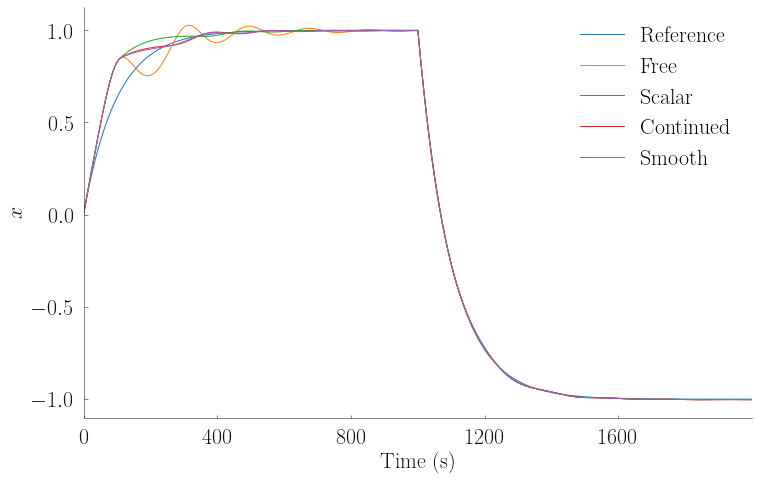

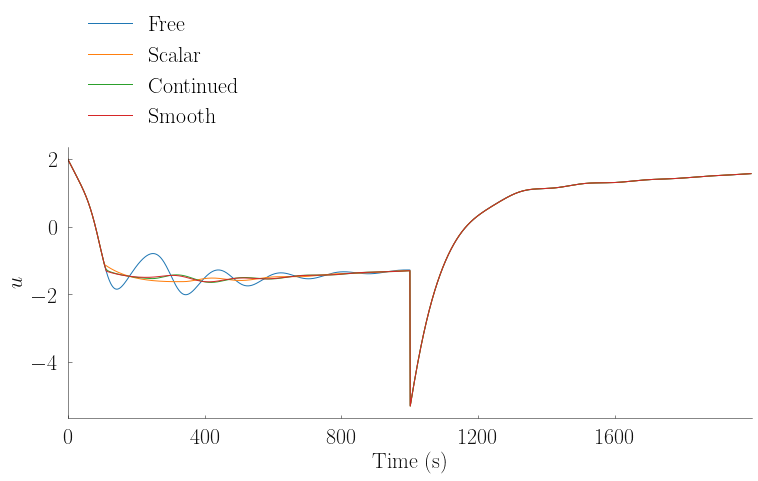

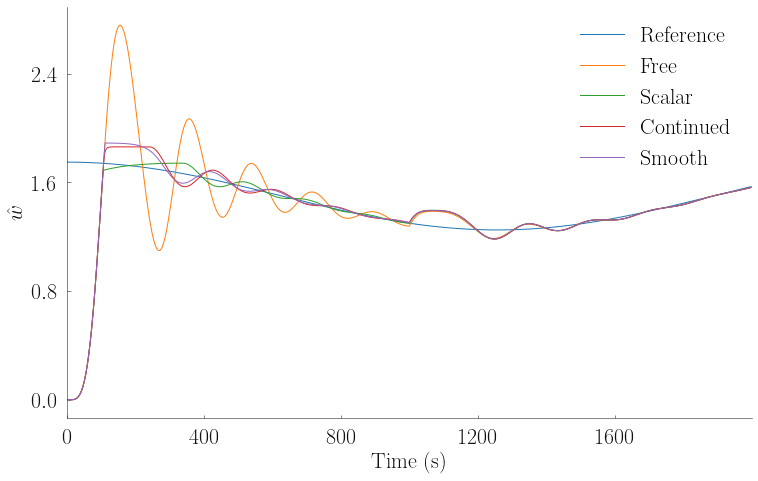

In [9]:
Plib.initialize() # initialize the library
Scope(initial=np.concatenate([xr_rec_scalar,
                              x_rec,
                              x_rec_scalar,
                              x_rec_continued,
                              x_rec_smooth],axis=1).T).show(params,
                                                            y_label='$x$',
                                                            legend = ('Reference', 'Free', 'Scalar', 'Continued', 'Smooth'),
                                                            line_width = 1)
Scope(initial=np.concatenate([u_rec,
                              u_rec_scalar,
                              u_rec_continued,
                              u_rec_smooth],axis=1).T).show(params,
                                                            y_label='$u$',
                                                            legend = ('Free', 'Scalar', 'Continued', 'Smooth'),
                                                            line_width = 1)
Scope(initial=np.concatenate([whatr_rec,
                              what_rec,
                              what_rec_scalar,
                              what_rec_continued,
                              what_rec_smooth],axis=1).T).show(params,
                                                            y_label='$\hat{w}$',
                                                            legend = ('Reference', 'Free', 'Scalar', 'Continued', 'Smooth'),
                                                            line_width = 1)